In [1]:
import numpy as np
from catboost import CatBoostClassifier, datasets
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

In [2]:
appetency_positive_steps = [200, 450, 890]
appetency_negative_steps = [1500, 3000, 6000, 12000, 24000, 49110]
upselling_positive_steps = [900, 1800, 3682]
upselling_negative_steps = [3000, 6000, 12000, 24000, 46318]

In [3]:
import re

def to_float_str(element):
    try:
        return str(float(element))
    except ValueError:
        return element



def get_dataset(target, max_positive=4000000000, max_negative=4000000000):
    targets = pd.read_csv(f'kdd/{target}.labels', names=['target'])['target']
    targets = targets.apply(lambda x: 1 if x == 1 else 0)
    data = pd.read_csv('kdd/kdd.data', sep='\t')
    data[target] = targets
    data = (
        pd
        .concat([
            data[data[target] == 1][:max_positive],
            data[data[target] == 0][:max_negative]
        ])
        .sample(frac=1)
        .reset_index(drop=True)
    )
    targets = data[target]
    data.drop([target], axis=1, inplace=True)
    
    categorical_features = {
        190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 209,
        210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228,
    }

    for i in categorical_features:
        data[data.columns[i]].fillna("?", inplace=True)
        data[data.columns[i]] = data[data.columns[i]].apply(lambda x: to_float_str(x))


    columns_to_impute = []
    for i, column in enumerate(data.columns):
        if i not in categorical_features and pd.isnull(data[column]).any():
            columns_to_impute.append(column)
    for column_name in columns_to_impute:
        data[column_name + "_imputed"] = pd.isnull(data[column_name]).astype(float)
        data[column_name].fillna(0, inplace=True)

    return data, targets, [data.columns[x] for x in categorical_features]


# Catboost (appetency)

In [71]:
catboost_scores = np.zeros(shape=(len(appetency_negative_steps), len(appetency_positive_steps)))
catboost_means = np.zeros(shape=(len(appetency_negative_steps), len(appetency_positive_steps)))
for i, positive in enumerate(tqdm(appetency_positive_steps)):
    for j, negative in enumerate(tqdm(appetency_negative_steps, leave=False)):
        X, y, cat_features = get_dataset('appetency', positive, negative)
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25)

        params = {'loss_function':'Logloss',
                  'eval_metric':'AUC',
                  'cat_features': cat_features,
                  'early_stopping_rounds': 200,
                  'verbose': False,  # 200, # output to stdout info about training process every 200 iterations
                 }
        cbc_1 = CatBoostClassifier(**params)
        cbc_1.fit(
            X_train, y_train,
            eval_set=(X_valid, y_valid),
            use_best_model=True,
            plot=False,
        )
        catboost_scores[j, i] = accuracy_score(y_valid, cbc_1.predict(X_valid))
        catboost_means[j, i] = cbc_1.predict(X_valid).mean()

## Keras (appetency)

In [72]:
keras_scores = np.zeros(shape=(len(appetency_negative_steps), len(appetency_positive_steps)))
keras_means = np.zeros(shape=(len(appetency_negative_steps), len(appetency_positive_steps)))
for i, positive in enumerate(tqdm(appetency_positive_steps)):
    for j, negative in enumerate(tqdm(appetency_negative_steps, leave=False)):
        X, y, cat_features = get_dataset('appetency', positive, negative)
        columns_to_onehot_encode = [x for x in cat_features if X[x].nunique() <= 50]
        columns_to_integer_encode = [x for x in cat_features if X[x].nunique() > 50]
        for col in X.columns:
            if col in columns_to_integer_encode:
                X[col] = X[col].astype('category').cat.codes.astype('float32')
            if col not in cat_features or col in columns_to_integer_encode:
                if X[col].max() == X[col].min():
                    col_range = 1
                else:
                    col_range = X[col].max() - X[col].min()
                X[col] = (X[col] - X[col].min()) / col_range
        X = pd.get_dummies(X, columns=columns_to_onehot_encode)
        X = X.astype('float32')
        y = y.astype('float32')
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25)
        
        model = keras.Sequential([
            keras.layers.Dense(32, activation='relu'),
            keras.layers.Dropout(0.2),
            keras.layers.Dense(32, activation='relu'),
            keras.layers.Dropout(0.2),
            keras.layers.Dense(1, activation='sigmoid'),
        ])
        model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor="val_loss",
                min_delta=0,
                patience=0,
                verbose=0,
                mode="auto",
                baseline=None,
                restore_best_weights=False,
            )
        ]
        model.fit(
            X_train, y_train,
            epochs=15, validation_data=(X_valid, y_valid),
            callbacks=callbacks, verbose=False,
        )

        test_loss, test_acc = model.evaluate(X_valid,  y_valid, verbose=0)
        
        keras_scores[j, i] = test_acc
        keras_means[j, i] = model.predict_classes(X_valid).mean()

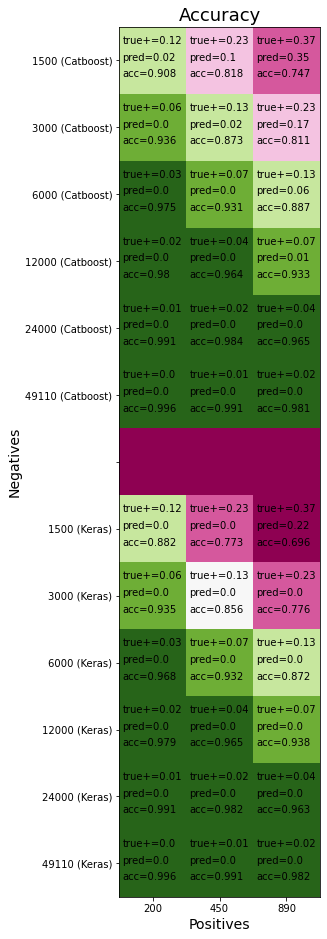

In [73]:
cmap = np.concatenate([
    catboost_scores,
    np.full((1, len(appetency_positive_steps)), min(catboost_scores.min(), keras_scores.min())),
    keras_scores
])
plt.figure(figsize=(12, 16))
plt.title(f'Accuracy', fontsize=18)
plt.imshow(cmap, cmap=plt.get_cmap("PiYG", 7))
plt.xlabel('Positives', fontsize=14)
plt.ylabel('Negatives', fontsize=14)
plt.xticks(range(len(appetency_positive_steps)), appetency_positive_steps)
plt.yticks(
    range(len(appetency_negative_steps)*2+1),
    [f'{x} (Catboost)' for x in appetency_negative_steps] + [''] + [f'{x} (Keras)' for x in appetency_negative_steps]
)
for i in range(len(appetency_negative_steps)):
    for j in range(len(appetency_positive_steps)):
        plt.text(j-0.45, i-0.25, f'true+={round(appetency_positive_steps[j] / (appetency_positive_steps[j] + appetency_negative_steps[i]), 2)}')
        plt.text(j-0.45, i, f'pred={round(catboost_means[i, j], 2)}')
        plt.text(j-0.45, i+0.25, f'acc={round(catboost_scores[i, j], 3)}')
        plt.text(j-0.45, i-0.25 + len(appetency_negative_steps) + 1, f'true+={round(appetency_positive_steps[j] / (appetency_positive_steps[j] + appetency_negative_steps[i]), 2)}')
        plt.text(j-0.45, i + len(appetency_negative_steps) + 1, f'pred={round(keras_means[i, j], 2)}')
        plt.text(j-0.45, i+0.25 + len(appetency_negative_steps) + 1, f'acc={round(keras_scores[i, j], 3)}')

# Plot Keras training

In [55]:
X, y, cat_features = get_dataset('appetency', max_negative=12000)
columns_to_onehot_encode = [x for x in cat_features if X[x].nunique() <= 50]
columns_to_integer_encode = [x for x in cat_features if X[x].nunique() > 50]
for col in X.columns:
    if col not in cat_features:
        if X[col].max() == X[col].min():
            col_range = 1
        else:
            col_range = X[col].max() - X[col].min()
        X[col] = (X[col] - X[col].min()) / col_range
    if col in columns_to_integer_encode:
        X[col] = X[col].astype('category').cat.codes
X = pd.get_dummies(X, columns=columns_to_onehot_encode)
X = X.astype('float32')
y = y.astype('float32')
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25)

scores = {}

In [60]:
for dropout_value in tqdm([0.25, 0.4, 0.5]):
    for layer1 in tqdm([32, 64, 128], leave=False):
        for layer2 in [32, 64, 128]:
            for layer3 in [0, 16]:
                layers = [
                    keras.layers.Dense(layer1, activation='relu'),
                    keras.layers.Dropout(dropout_value),
                    keras.layers.Dense(layer2, activation='relu'),
                    keras.layers.Dropout(dropout_value),
                ]
                if layer3:
                    layers += [
                        keras.layers.Dense(layer3, activation='relu'),
                        keras.layers.Dropout(dropout_value),
                    ]
                layers += [
                    keras.layers.Dense(1, activation='sigmoid'),
                ]
                model = keras.Sequential(layers)
                model.compile(optimizer='adam',
                              loss='binary_crossentropy',
                              metrics=['accuracy'])
                callbacks = [
                    tf.keras.callbacks.EarlyStopping(
                        monitor="val_loss",
                        min_delta=0,
                        patience=0,
                        verbose=0,
                        mode="auto",
                        baseline=None,
                        restore_best_weights=False,
                    )
                ]
                history = model.fit(
                    X_train, y_train,
                    epochs=12, validation_data=(X_valid, y_valid),
                    callbacks=callbacks, verbose=False,
                )

                test_loss, test_acc = model.evaluate(X_valid,  y_valid, verbose=0)
                key = 'l1_{}_l2_{}_l3_{}_dr_{}'.format(layer1, layer2, layer3, dropout_value)
                scores[key] = history.history['val_accuracy']

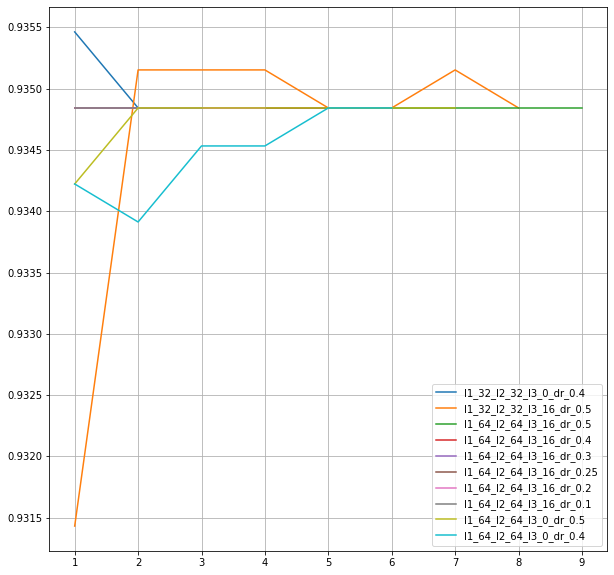

In [61]:
by_max = {(max(values), key): key for (key, values) in scores.items()}
best_key = [by_max[x] for x in sorted(by_max, reverse=True)[:10]]
plt.figure(figsize=(10, 10))
plt.grid(True)
for key in best_key:
    plt.plot(range(1, len(scores[key])+1), scores[key], label=key)
plt.legend()
plt.show()

# Catboost (upselling)

In [74]:
catboost_scores = np.zeros(shape=(len(upselling_negative_steps), len(upselling_positive_steps)))
catboost_means = np.zeros(shape=(len(upselling_negative_steps), len(upselling_positive_steps)))
for i, positive in enumerate(tqdm(upselling_positive_steps)):
    for j, negative in enumerate(tqdm(upselling_negative_steps, leave=False)):
        X, y, cat_features = get_dataset('upselling', positive, negative)
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25)

        params = {'loss_function':'Logloss',
                  'eval_metric':'AUC',
                  'cat_features': cat_features,
                  'early_stopping_rounds': 200,
                  'verbose': False,  # 200, # output to stdout info about training process every 200 iterations
                 }
        cbc_1 = CatBoostClassifier(**params)
        cbc_1.fit(
            X_train, y_train,
            eval_set=(X_valid, y_valid),
            use_best_model=True,
            plot=False,
        )
        catboost_scores[j, i] = accuracy_score(y_valid, cbc_1.predict(X_valid))
        catboost_means[j, i] = cbc_1.predict(X_valid).mean()

## Keras (upselling)

In [75]:
keras_scores = np.zeros(shape=(len(upselling_negative_steps), len(upselling_positive_steps)))
keras_means = np.zeros(shape=(len(upselling_negative_steps), len(upselling_positive_steps)))
for i, positive in enumerate(tqdm(upselling_positive_steps)):
    for j, negative in enumerate(tqdm(upselling_negative_steps, leave=False)):
        X, y, cat_features = get_dataset('upselling', positive, negative)
        columns_to_onehot_encode = [x for x in cat_features if X[x].nunique() <= 50]
        columns_to_integer_encode = [x for x in cat_features if X[x].nunique() > 50]
        for col in X.columns:
            if col in columns_to_integer_encode:
                X[col] = X[col].astype('category').cat.codes.astype('float32')
            if col not in cat_features or col in columns_to_integer_encode:
                if X[col].max() == X[col].min():
                    col_range = 1
                else:
                    col_range = X[col].max() - X[col].min()
                X[col] = (X[col] - X[col].min()) / col_range
        X = pd.get_dummies(X, columns=columns_to_onehot_encode)
        X = X.astype('float32')
        y = y.astype('float32')
        X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25)
        
        model = keras.Sequential([
            keras.layers.Dense(32, activation='relu'),
            keras.layers.Dropout(0.2),
            keras.layers.Dense(32, activation='relu'),
            keras.layers.Dropout(0.2),
            keras.layers.Dense(1, activation='sigmoid'),
        ])
        model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor="val_loss",
                min_delta=0,
                patience=0,
                verbose=0,
                mode="auto",
                baseline=None,
                restore_best_weights=False,
            )
        ]
        model.fit(
            X_train, y_train,
            epochs=15, validation_data=(X_valid, y_valid),
            callbacks=callbacks, verbose=False,
        )

        test_loss, test_acc = model.evaluate(X_valid,  y_valid, verbose=0)
        
        keras_scores[j, i] = test_acc
        keras_means[j, i] = model.predict_classes(X_valid).mean()

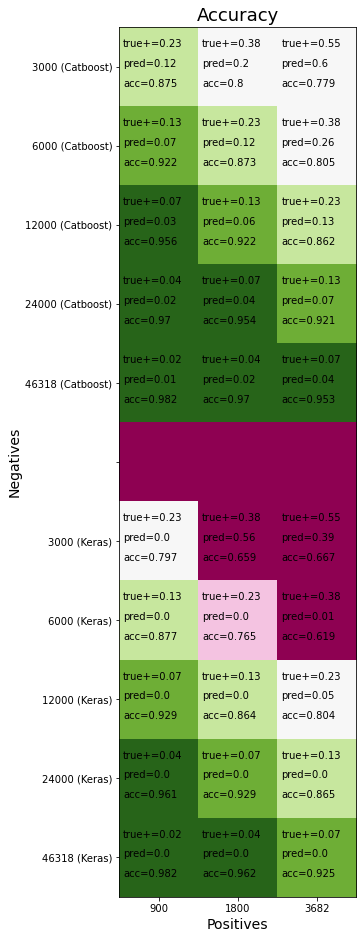

In [76]:
cmap = np.concatenate([
    catboost_scores,
    np.full((1, len(upselling_positive_steps)), min(catboost_scores.min(), keras_scores.min())),
    keras_scores
])
plt.figure(figsize=(12, 16))
plt.title(f'Accuracy', fontsize=18)
plt.imshow(cmap, cmap=plt.get_cmap("PiYG", 7))
plt.xlabel('Positives', fontsize=14)
plt.ylabel('Negatives', fontsize=14)
plt.xticks(range(len(upselling_positive_steps)), upselling_positive_steps)
plt.yticks(
    range(len(upselling_negative_steps)*2+1),
    [f'{x} (Catboost)' for x in upselling_negative_steps] + [''] + [f'{x} (Keras)' for x in upselling_negative_steps]
)
for i in range(len(upselling_negative_steps)):
    for j in range(len(upselling_positive_steps)):
        plt.text(j-0.45, i-0.25, f'true+={round(upselling_positive_steps[j] / (upselling_positive_steps[j] + upselling_negative_steps[i]), 2)}')
        plt.text(j-0.45, i, f'pred={round(catboost_means[i, j], 2)}')
        plt.text(j-0.45, i+0.25, f'acc={round(catboost_scores[i, j], 3)}')
        plt.text(j-0.45, i-0.25 + len(upselling_negative_steps) + 1, f'true+={round(upselling_positive_steps[j] / (upselling_positive_steps[j] + upselling_negative_steps[i]), 2)}')
        plt.text(j-0.45, i + len(upselling_negative_steps) + 1, f'pred={round(keras_means[i, j], 2)}')
        plt.text(j-0.45, i+0.25 + len(upselling_negative_steps) + 1, f'acc={round(keras_scores[i, j], 3)}')